In [32]:
import folium
import pandas as pd
import re
import json
from folium import plugins
from shapely.geometry import shape, Point


In [94]:
df = pd.read_csv("/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/Bus_Stops_-_New_Network_July_2020.csv")
df.head(100)
#len(df)

,the_geom,Id,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,stop_url,loc_type,wheelchair,Zip Codes,Suburb
0,POINT (149.097304 -35.419885),0,1443,NaN,Cockcroft Av before Kneeshaw St,-35.419885,149.097304,NaN,NaN,0,0,NaN,46.0
1,POINT (149.133149 -35.306076000000004),0,2258,NaN,Barton Bus Stn Plt 1,-35.306076,149.133149,NaN,NaN,0,0,NaN,62.0
2,POINT (149.063721 -35.259589),0,4641,NaN,Cook Shops Templeton St,-35.259589,149.063721,NaN,NaN,0,0,NaN,42.0
3,POINT (149.028441 -35.230096),0,4990,NaN,Castieau St before Fullagar Cr,-35.230096,149.028441,NaN,NaN,0,0,NaN,88.0
4,POINT (149.107132 -35.355484999999994),0,2102,NaN,Kareelah Vsta after Gerogery Pl,-35.355485,149.107132,NaN,NaN,0,0,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,POINT (149.16751299999999 -35.326234),0,1766,NaN,Barrier St before Ipswich St,-35.326234,149.167513,NaN,NaN,0,0,NaN,64.0
96,POINT (149.164438 -35.300218),0,3067,NaN,Parnell St after Plant Rd,-35.300218,149.164438,NaN,NaN,0,0,NaN,109.0
97,POINT (149.161435 -35.200872),0,6070,NaN,Nullarbor Av opp Phantom St,-35.200872,149.161435,NaN,NaN,0,0,NaN,67.0
98,POINT (149.076987 -35.31947900000001),0,2022,NaN,Throssell St after Prendergast St,-35.319479,149.076987,NaN,NaN,0,0,NaN,106.0


In [12]:
df_train= pd.read_csv("/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/LightRailStops.csv")
df_train
#len(df_train)

,STAGE,STOPNAME,the_geom,OBJECTID
0,1,Gungahlin Place,POINT (149.1350746227217 -35.185565657262195),1
1,1,Manning Clark North,POINT (149.1440022032628 -35.18707790082262),2
2,1,Mapleton Avenue,POINT (149.15090938491667 -35.19384117440109),3
3,1,Nullarbor Avenue,POINT (149.1491872626445 -35.20105746044515),4
4,1,Well Station Drive,POINT (149.1474088206555 -35.208726700156475),5
5,1,EPIC and Racecourse,POINT (149.14435918703418 -35.228293267727224),6
6,1,Phillip Avenue,POINT (149.14371129168518 -35.235927896111946),7
7,1,Swinden Street,POINT (149.13464806483543 -35.24416198657027),8
8,1,Dickson Interchange,POINT (149.13407574176165 -35.24852999278801),9
9,1,Macarthur Avenue,POINT (149.1321063440868 -35.260815176721515),10


In [4]:
def reverse(list):
    mutatedList = []
    for i in list:
        i.reverse()
        mutatedList.append(i)
    list=mutatedList[:]
    return mutatedList

In [5]:
with open('/mapr/datalake.test.act.gov.au/Data/TCCS/TrafficData/SourceData/map.geojson') as f:
    geo_json = json.load(f)

In [5]:
with open('/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/cra_suburb.geojson') as f:
    geo_json_cra = json.load(f)

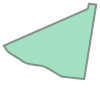

In [18]:
cp = shape(centrepoint)
cp

In [16]:
def getlatlon(point):
    lat=float(((point.replace('(',' ')).replace(')',' ')).split()[2])
    lon=float(((point.replace('(',' ')).replace(')',' ')).split()[1])
    return lat,lon

In [4]:
#Create a dataframe to read the geojson and exytract suburb,Lat and Lon 
filepath='/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/cra_suburb.geojson'
def getdfsuburb(csvpath):
    with open(csvpath) as f:
        geo_json_cra = json.load(f)
    feature=geo_json_cra['features']
    #Create a columns for suburb
    df_table_suburb = pd.DataFrame(columns = ['SuburbId','SuburbName', "SuburbLat", "SuburbLon", "PrecinctFK"])
    for i in range(0,len(feature)):
        df_table_suburb.loc[i,'SuburbId']=feature[i]['properties']['loc_pid']
        df_table_suburb.loc[i,'SuburbName'] = feature[i]['properties']['act_loca_2']
        centrepoint = shape(feature[i]['geometry'])
        latlon=str(centrepoint.centroid)
        lat=float(((latlon.replace('(',' ')).replace(')',' ')).split()[2])
        lon=float(((latlon.replace('(',' ')).replace(')',' ')).split()[1])
        df_table_suburb.loc[i,'SuburbLat']=lat
        df_table_suburb.loc[i,'SuburbLon']=lon
    f.close()
    #df_table_suburb.to_csv("/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/suburb.csv")
    return df_table_suburb
data_suburb = getdfsuburb(filepath)

In [5]:
data_suburb

,SuburbId,SuburbName,SuburbLat,SuburbLon,PrecinctFK
0,ACT105,TURNER,-35.2689,149.125,NaN
1,ACT125,WATSON,-35.2348,149.159,NaN
2,ACT701,MITCHELL,-35.2189,149.136,NaN
3,ACT102,DICKSON,-35.2528,149.142,NaN
4,ACT103,O'CONNOR,-35.2566,149.116,NaN
5,ACT106,BRADDON,-35.2708,149.136,NaN
6,ACT110,CAMPBELL,-35.2914,149.158,NaN
7,ACT211,PARKES,-35.2959,149.135,NaN
8,ACT104,AINSLIE,-35.2622,149.148,NaN
9,ACT108,CITY,-35.2813,149.129,NaN


In [48]:
def verify_bounds(point,feature):
     for feat in feature:
        polygon = shape(feat['geometry'])
        if polygon.contains(point):
            return "True"
        else:
            return "False"

In [66]:
#Create DF for bus stops and tram stops and store it in an other form of csv 
busfilepath='/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/Bus_Stops_-_New_Network_July_2020.csv'
tramstoppath='/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/LightRailStops.csv'
cra_bounds='/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/cra_suburb.geojson'
def getdflocation(buspath, trampath, cra_bounds):
    df_bus=pd.read_csv(buspath)
    df_tram=pd.read_csv(trampath)
    with open(filepath) as f:
        geo_json_cra = json.load(f)
    feature=geo_json_cra['features']
    df_location=pd.DataFrame(columns = ['Reporting_Loc_Id','Reporting_Loc_Type',"Reporting_Loc_Name", "Loc_Lat", "Loc_Lon","ActiveFlag", "PrecinctFK"])
    loctype="Bus Stop"
    count=0
    for i in range(0,len(df_bus)):
        lat,lon=getlatlon(df_bus.loc[i,"the_geom"])
        point=Point(lon, lat)
        #print(point)
        #pointverify=verify_bounds(point,feature)
        for feat in feature:
            polygon = shape(feat['geometry'])
            if polygon.contains(point):
                df_location.loc[count,"Loc_Lat"],df_location.loc[count,"Loc_Lon"]= lat,lon
                df_location.loc[count,"Reporting_Loc_Type"]=loctype
                df_location.loc[count,"Reporting_Loc_Id"]=df_bus.loc[i,"stop_id"]
                df_location.loc[count,"Reporting_Loc_Name"]=df_bus.loc[i,"stop_name"]
                count=count+1    
            #print(type(df_bus.loc[i,"the_geom"]))
            #print(df_location.loc[count,"Loc_Lat"])
    loctype="Tram Stop"
    feature=geo_json_cra['features']
    for i in range(0,len(df_tram)):
        lat,lon=getlatlon(df_tram.loc[i,"the_geom"])
        point=Point(lon, lat)
        print(point)
        for feat in feature:
            polygon = shape(feat['geometry'])
            if polygon.contains(point):
                df_location.loc[count,"Loc_Lat"],df_location.loc[count,"Loc_Lon"]= lat,lon
                df_location.loc[count,"Reporting_Loc_Type"]=loctype
                df_location.loc[count,"Reporting_Loc_Id"]=df_tram.loc[i,"OBJECTID"]
                df_location.loc[count,"Reporting_Loc_Name"]=df_tram.loc[i,"STOPNAME"]
                count=count+1
    #df_location.to_csv("/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/reporting_location.csv")
    return df_location

In [67]:
df_loc = getdflocation(busfilepath,tramstoppath,cra_bounds)

POINT (149.097304 -35.419885)
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
POINT (149.133149 -35.306076)
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
POINT (149.063721 -35.259589)
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
POINT (149.028441 -35.230096)
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'

In [71]:
df_loc.to_csv("/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/reporting_location.csv")

In [20]:
with open(filepath) as f:
    geo_json_cra = json.load(f)
feature=geo_json_cra['features']

In [28]:
for feat in feature:
    print(shape(feat["geometry"]))

MULTIPOLYGON (((149.12528413 -35.27529637, 149.12517185 -35.27528417, 149.1250451 -35.27527039, 149.12218761 -35.27356261, 149.12216324 -35.27354818, 149.12213872 -35.27353391, 149.12211406 -35.27351981, 149.12208925 -35.27350588, 149.1220643 -35.27349213, 149.12203921 -35.27347854, 149.12201398 -35.27346513, 149.12198861 -35.2734519, 149.12196311 -35.27343884, 149.12193747 -35.27342596, 149.12191171 -35.27341326, 149.12188581 -35.27340073, 149.12185979 -35.27338839, 149.12183364 -35.27337622, 149.12180736 -35.27336424, 149.12178097 -35.27335243, 149.12175445 -35.27334081, 149.12172782 -35.27332938, 149.12170107 -35.27331813, 149.1216742 -35.27330706, 149.12164722 -35.27329618, 149.12162013 -35.27328549, 149.12159293 -35.27327498, 149.12156563 -35.27326466, 149.12153822 -35.27325453, 149.1215107 -35.2732446, 149.12148309 -35.27323485, 149.12145537 -35.27322529, 149.12142756 -35.27321593, 149.12139966 -35.27320675, 149.12137166 -35.27319777, 149.12134356 -35.27318899, 149.12131538 -35.2

In [41]:

point=Point(149.133404, -35.250884)

In [43]:
for feat in feature:
    polygon = shape(feat['geometry'])
    if polygon.contains(point):
        print('Found containing polygon:')

Found containing polygon:


In [72]:
co_ordinates = geo_json['features'][0]['geometry']['coordinates']
co_ordinates_r = reverse(co_ordinates)
co_ordinates_r

NameError: name 'geo_json' is not defined

In [7]:
geo_json['features'][0]['geometry']['coordinates']=co_ordinates_r

In [95]:
def stopnamepoints(stopname, stopid):
    print(stopname)
    match="Platform "
    not_match="Set Down Only"
    if match in stopname and not_match not in stopname:
        stopname_first=stopname.split()[0]
        for i in range (0, len(df_train)):
            if stopname_first in df_train.loc[i,'STOPNAME']:
                lat=float((((df_train.loc[i,'the_geom']).replace('(',' ')).replace(')',' ')).split()[2])
                lon=float((((df_train.loc[i,'the_geom']).replace('(',' ')).replace(')',' ')).split()[1]) 
                return lat,lon
    else:
        stopname_first=stopname.split()[0]
        for i in range (0, len(df)):
            if stopid == df.loc[i,'stop_id']:
                lat=float((((df.loc[i,'the_geom']).replace('(',' ')).replace(')',' ')).split()[2])
                lon=float((((df.loc[i,'the_geom']).replace('(',' ')).replace(')',' ')).split()[1]) 
                return lat,lon

In [96]:
ids="0401"
id1=int(ids)
print(id1)
name="MacFarlane Burnet Av after 1st Eccles Cct"

401


In [97]:
stopnamepoints(name,id1)

MacFarlane Burnet Av after 1st Eccles Cct


(-35.21606, 149.00305)

In [73]:
df_tag = pd.read_csv("/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/01-may-2020.csv",header = 0,skiprows = [0,1], dtype = str )
df_tag = df_tag.fillna(0)
df_tag.head()


,Unnamed: 0,00,01,05,06,07,08,09,10,11,...,14.1,15.1,16.1,17.1,18.1,19.1,20.1,21.1,22.1,23.1
0,0201: Fremantle Dr after 1st McKail Cr,0,0,0,0,less than 10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0401: MacFarlane Burnet Av after 1st Eccles Cct,0,0,less than 10,less than 10,less than 10,less than 10,0,0,0,...,less than 10,0,less than 10,0,less than 10,less than 10,0,0,0,0
2,0402: MacFarlane Burnet Av before Hollows Cct,0,0,0,0,less than 10,0,0,0,0,...,0,less than 10,less than 10,0,0,0,0,0,0,0
3,0403: MacFarlane Burnet Av after Hollows Cct,0,0,0,0,less than 10,0,0,less than 10,0,...,0,less than 10,0,0,0,0,0,0,0,0
4,0405: MacFarlane Burnet Av after Constance Sto...,0,0,0,0,0,0,less than 10,less than 10,0,...,less than 10,0,0,less than 10,0,0,0,0,0,0


In [74]:
df_tag2 = pd.read_csv("/mapr/datalake.test.act.gov.au/Data/TCCS/MyWay/SourceData/01-may-2020.csv", dtype=str)
k = str(df_tag2.loc[0])
k.split()[0]
#df_tag2.iloc[0]=0
#df_tag2 = df_tag2[1:]
df_tag2.drop(df_tag2.index[0], inplace = True)

df_tag2 = df_tag2.fillna(0)
#df_tag2.drop(df_tag2.columns[1],axis=1, inplace = True)


In [75]:
df_tag2

,01-May-2020,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42
1,0,00,01,05,06,07,08,09,10,11,...,14,15,16,17,18,19,20,21,22,23
2,0201: Fremantle Dr after 1st McKail Cr,0,0,0,0,less than 10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0401: MacFarlane Burnet Av after 1st Eccles Cct,0,0,less than 10,less than 10,less than 10,less than 10,0,0,0,...,less than 10,0,less than 10,0,less than 10,less than 10,0,0,0,0
4,0402: MacFarlane Burnet Av before Hollows Cct,0,0,0,0,less than 10,0,0,0,0,...,0,less than 10,less than 10,0,0,0,0,0,0,0
5,0403: MacFarlane Burnet Av after Hollows Cct,0,0,0,0,less than 10,0,0,less than 10,0,...,0,less than 10,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,945: Dickson Interchange Plt 1,0,0,0,less than 10,less than 10,less than 10,less than 10,less than 10,less than 10,...,less than 10,less than 10,less than 10,less than 10,less than 10,0,less than 10,0,0,0
1847,946: Dickson Interchange Plt 2,0,0,0,less than 10,less than 10,less than 10,less than 10,less than 10,less than 10,...,less than 10,less than 10,less than 10,less than 10,less than 10,less than 10,less than 10,less than 10,0,less than 10
1848,956: Cohen St Interchange Arrivals,0,0,0,less than 10,less than 10,less than 10,less than 10,less than 10,less than 10,...,less than 10,less than 10,less than 10,less than 10,less than 10,less than 10,0,0,0,0
1849,959: Cohen St Interchange,0,0,0,less than 10,less than 10,less than 10,less than 10,0,less than 10,...,less than 10,less than 10,less than 10,0,0,0,0,0,0,0


In [102]:
date_ref = "01-May-2020"
df_tag_transformed = pd.DataFrame(columns = ['StopId','StopName','TimeStamp','TagON', 'TagOFF', "Lat", "Lon","TagOnOff","LessThan10Flag"])
df_tag_transformed.columns

for i in range (0,(len(df_tag)-1)):
    #print(df_tag.loc[i])
    #print(df_tag.loc[i][0])
    stop_details = df_tag.loc[i][0]
    stop_id_search = re.search("[0-9]+[:]",stop_details)
    stop_id_span = stop_id_search.span()
    stop_id = stop_details[stop_id_span[0]:stop_id_span[1]-1]
    #print(stop_id)
    stop_id=int(stop_id)
    stop_name = stop_details[stop_id_span[1]+1:]
    #print(stop_name)
    #match=" "
    #not_match="Set Down Only"
    #if match in stop_name and not_match not in stop_name:
    print(stop_name)
    df_tag_transformed.loc[i,'StopId'] = stop_id
    df_tag_transformed.loc[i,'StopName'] = stop_name
        #print(len(df_tag.loc[i]))
    time_ref = 0
    df_tag_transformed.loc[i,'TimeStamp']=date_ref+" "+str(time_ref)+":00"
    df_tag_transformed.loc[i,'TimeStamp']=pd.to_datetime(df_tag_transformed.loc[i,'TimeStamp'],format = "%d-%b-%Y %H:%M")
    df_tag_transformed.loc[i,'TagON']= df_tag.loc[i][1]
    df_tag_transformed.loc[i,'TagOFF']= df_tag.loc[i][22]
    lat, lon = stopnamepoints(stop_name, stop_id)
    df_tag_transformed.loc[i,'Lat']=lat
    df_tag_transformed.loc[i,'Lon']=lon
    for j in range (1, 2):
        time_ref = time_ref + j
        lat, lon = stopnamepoints(stop_name, stop_id)
        #df_tag_transformed.loc[i,'Time Stamp'] = str(date_ref+" "+str(time_ref))
            #print(df_tag.loc[i][j])
        value = df_tag.loc[i][j]
        value_off = df_tag.loc[i][(j+22)]
        time_stamp = date_ref+" "+str(time_ref)+":00"
        time_stamp= pd.to_datetime(time_stamp,format = "%d-%b-%Y %H:%M")
        df_tag_transformed = df_tag_transformed.append({'StopId': stop_id,
                                   'StopName': stop_name,
                                   'TimeStamp': time_stamp,
                                   'TagON': value,
                                   'TagOFF': value_off,
                                   'Lat': lat,
                                   'Lon': lon
                                      }, ignore_index=True)
    time_ref = 5
    for j in range (3, 22):
        value = df_tag.loc[i][j]
        value_off = df_tag.loc[i][(j+21)]
        lat, lon = stopnamepoints(stop_name, stop_id)
            #print(time_ref)
            #df_tag_transformed.loc[i,'Time Stamp'] = str(date_ref+" "+str(time_ref))
        time_stamp = date_ref+" "+str(time_ref)+":00"
            #print(df_tag.loc[i][j])
        time_stamp= pd.to_datetime(time_stamp,format = "%d-%b-%Y %H:%M")
        time_ref = time_ref + 1 
        df_tag_transformed = df_tag_transformed.append({'StopId': stop_id,
                                   'StopName': stop_name,
                                   'TimeStamp': time_stamp,
                                   'TagON': value,
                                   'TagOFF': value_off,
                                   'Lat': lat,
                                   'Lon': lon
                                      }, ignore_index=True)



Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
Fremantle Dr after 1st McKail Cr
MacFarlane Burnet Av after 1st Eccles Cct
MacFarlane Burnet Av after 1st Eccles Cct
MacFarlane Burnet Av after 1st Eccles Cct
MacFarlane Burnet Av after 1st Eccles Cct
MacFarlane Burnet Av after 1st Eccles Cct
MacFarlane Burnet Av after 1st Eccles Cct
MacFarlane Burnet Av a

TypeError: cannot unpack non-iterable NoneType object

In [105]:
df_tag_transformed


,StopId,StopName,TimeStamp,TagON,TagOFF,Lat,Lon,TagOnOff,LessThan10Flag
0,201,Fremantle Dr after 1st McKail Cr,2020-05-01 00:00:00,0,0,-35.347,149.048,NaN,NaN
1,401,MacFarlane Burnet Av after 1st Eccles Cct,2020-05-01 00:00:00,0,0,-35.2161,149.003,NaN,NaN
2,402,MacFarlane Burnet Av before Hollows Cct,2020-05-01 00:00:00,0,0,-35.2128,149.004,NaN,NaN
3,403,MacFarlane Burnet Av after Hollows Cct,2020-05-01 00:00:00,0,0,-35.2127,149.004,NaN,NaN
4,405,MacFarlane Burnet Av after Constance Stone St,2020-05-01 00:00:00,0,0,-35.2093,149.003,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6696,1609,St Edmunds College McMillan Cr SSO,2020-05-01 19:00:00,0,0,-35.3232,149.146,NaN,NaN
6697,1609,St Edmunds College McMillan Cr SSO,2020-05-01 20:00:00,0,0,-35.3232,149.146,NaN,NaN
6698,1609,St Edmunds College McMillan Cr SSO,2020-05-01 21:00:00,0,0,-35.3232,149.146,NaN,NaN
6699,1609,St Edmunds College McMillan Cr SSO,2020-05-01 22:00:00,0,0,-35.3232,149.146,NaN,NaN


In [16]:
df_tag_transformed=df_tag_transformed.replace({'less than 10': 10})

In [17]:
df_tag_transformed.loc[0,"StopName"]

'Gungahlin Place Platform 1'

In [18]:
df_tag_heat = df_tag_transformed
df_tag_heat

,StopId,StopName,TimeStamp,TagON,TagOFF,Lat,Lon
0,8100,Gungahlin Place Platform 1,2020-05-01 00:00:00,0,0,-35.185566,149.135075
1,8100,Gungahlin Place Platform 1,2020-05-01 01:00:00,0,0,-35.185566,149.135075
2,8100,Gungahlin Place Platform 1,2020-05-01 05:00:00,10,10,-35.185566,149.135075
3,8100,Gungahlin Place Platform 1,2020-05-01 06:00:00,21.0,10,-35.185566,149.135075
4,8100,Gungahlin Place Platform 1,2020-05-01 07:00:00,32.0,10,-35.185566,149.135075
...,...,...,...,...,...,...,...
268,8128,Alinga Street Platform 1,2020-05-01 19:00:00,10,10,-35.278210,149.129281
269,8128,Alinga Street Platform 1,2020-05-01 20:00:00,0,0,-35.278210,149.129281
270,8128,Alinga Street Platform 1,2020-05-01 21:00:00,0,0,-35.278210,149.129281
271,8128,Alinga Street Platform 1,2020-05-01 22:00:00,0,0,-35.278210,149.129281


In [19]:
data=[]
time=[]
tagon = []
tagoff = []
for i in range (0, len(df_tag_transformed)):
    if df_tag_transformed.loc[i,"StopName"] == 'Alinga Street Platform 1':
    #print(int(float(df_tag_transformed.loc[i,"TagON"])))
        #print(df_tag_transformed.loc[i,"TimeStamp"])
        tagon.append(int(float(df_tag_transformed.loc[i,"TagON"])))
        tagoff.append(int(float(df_tag_transformed.loc[i,"TagOFF"])))
    #data.append([df_tag_transformed.loc[i,"Lat"], df_tag_transformed.loc[i,"Lon"], (int(float(df_tag_transformed.loc[i,"TagON"]))*1000)])
        time.append(df_tag_transformed.loc[i,"TimeStamp"])
    
time1=time
#data1=data
#print(data1)
#print(time1)
tagon
tagoff

[0, 0, 0, 10, 46, 75, 56, 0, 10, 0, 0, 10, 15, 11, 19, 10, 10, 0, 0, 0, 0]

In [21]:
time1

[Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-05-01 01:00:00'),
 Timestamp('2020-05-01 05:00:00'),
 Timestamp('2020-05-01 06:00:00'),
 Timestamp('2020-05-01 07:00:00'),
 Timestamp('2020-05-01 08:00:00'),
 Timestamp('2020-05-01 09:00:00'),
 Timestamp('2020-05-01 10:00:00'),
 Timestamp('2020-05-01 11:00:00'),
 Timestamp('2020-05-01 12:00:00'),
 Timestamp('2020-05-01 13:00:00'),
 Timestamp('2020-05-01 14:00:00'),
 Timestamp('2020-05-01 15:00:00'),
 Timestamp('2020-05-01 16:00:00'),
 Timestamp('2020-05-01 17:00:00'),
 Timestamp('2020-05-01 18:00:00'),
 Timestamp('2020-05-01 19:00:00'),
 Timestamp('2020-05-01 20:00:00'),
 Timestamp('2020-05-01 21:00:00'),
 Timestamp('2020-05-01 22:00:00'),
 Timestamp('2020-05-01 23:00:00')]

In [20]:
newtime = [i.strftime('%Y-%m-%d %H:%M') for i in time1]
newtime

['2020-05-01 00:00',
 '2020-05-01 01:00',
 '2020-05-01 05:00',
 '2020-05-01 06:00',
 '2020-05-01 07:00',
 '2020-05-01 08:00',
 '2020-05-01 09:00',
 '2020-05-01 10:00',
 '2020-05-01 11:00',
 '2020-05-01 12:00',
 '2020-05-01 13:00',
 '2020-05-01 14:00',
 '2020-05-01 15:00',
 '2020-05-01 16:00',
 '2020-05-01 17:00',
 '2020-05-01 18:00',
 '2020-05-01 19:00',
 '2020-05-01 20:00',
 '2020-05-01 21:00',
 '2020-05-01 22:00',
 '2020-05-01 23:00']

In [21]:
df_tag_transformed.loc[0,"TimeStamp"].strftime('%Y-%m-%d %H:%M')

'2020-05-01 00:00'

In [25]:
for i in range(0,len(df_tag_heat)):
    print(df_tag_heat.loc[i,"TimeStamp"])
    print(df_tag_heat.loc[i,"TimeStamp"].strftime('%Y-%m-%d %H:%M'))
    df_tag_heat.loc[i,"TimeStamp"]=df_tag_heat.loc[i,"TimeStamp"].strftime('%Y-%m-%d %H:%M')

2020-05-01 00:00:00
2020-05-01 00:00
2020-05-01 01:00:00
2020-05-01 01:00
2020-05-01 05:00:00
2020-05-01 05:00
2020-05-01 06:00:00
2020-05-01 06:00
2020-05-01 07:00:00
2020-05-01 07:00
2020-05-01 08:00:00
2020-05-01 08:00
2020-05-01 09:00:00
2020-05-01 09:00
2020-05-01 10:00:00
2020-05-01 10:00
2020-05-01 11:00:00
2020-05-01 11:00
2020-05-01 12:00:00
2020-05-01 12:00
2020-05-01 13:00:00
2020-05-01 13:00
2020-05-01 14:00:00
2020-05-01 14:00
2020-05-01 15:00:00
2020-05-01 15:00
2020-05-01 16:00:00
2020-05-01 16:00
2020-05-01 17:00:00
2020-05-01 17:00
2020-05-01 18:00:00
2020-05-01 18:00
2020-05-01 19:00:00
2020-05-01 19:00
2020-05-01 20:00:00
2020-05-01 20:00
2020-05-01 21:00:00
2020-05-01 21:00
2020-05-01 22:00:00
2020-05-01 22:00
2020-05-01 23:00:00
2020-05-01 23:00
2020-05-01 00:00:00
2020-05-01 00:00
2020-05-01 01:00:00
2020-05-01 01:00
2020-05-01 05:00:00
2020-05-01 05:00
2020-05-01 06:00:00
2020-05-01 06:00
2020-05-01 07:00:00
2020-05-01 07:00
2020-05-01 08:00:00
2020-05-01 08:00
2

In [26]:
df_tag_heat.head(100)

,StopId,StopName,TimeStamp,TagON,TagOFF,Lat,Lon
0,8100,Gungahlin Place Platform 1,2020-05-01 00:00,0,0,-35.185566,149.135075
1,8100,Gungahlin Place Platform 1,2020-05-01 01:00,0,0,-35.185566,149.135075
2,8100,Gungahlin Place Platform 1,2020-05-01 05:00,10,10,-35.185566,149.135075
3,8100,Gungahlin Place Platform 1,2020-05-01 06:00,21.0,10,-35.185566,149.135075
4,8100,Gungahlin Place Platform 1,2020-05-01 07:00,32.0,10,-35.185566,149.135075
...,...,...,...,...,...,...,...
95,8110,Well Station Drive Platform 1,2020-05-01 14:00,10,10,-35.208727,149.147409
96,8110,Well Station Drive Platform 1,2020-05-01 15:00,10,10,-35.208727,149.147409
97,8110,Well Station Drive Platform 1,2020-05-01 16:00,10,10,-35.208727,149.147409
98,8110,Well Station Drive Platform 1,2020-05-01 17:00,10,10,-35.208727,149.147409
